In [ ]:
!pip install ../

In [1]:
import codex.codex as codex

# requirements
import sys
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2.3.0+cu121
0.18.0+cu121


In [2]:
def load_json(fp):
    with open(fp) as f:
        j = json.load(f)
    return j


def cc_results_t(set_name, coverage: dict, element: str, strengths):
    print(coverage.keys())
    for t in strengths:
        print(
            "{} | {} for {}-way interactions: {}".format(
                set_name, element, t, coverage[t][element]
            )
        )
        if t == 3:
            print()

    return  # [coverage[t][element] for t in strengths]


def sdcc_results_t(set_name, coverage: dict, element: str, strengths, direction):
    print(coverage.keys())
    for t in strengths:
        print(
            "{} {} over {}-way interactions: {}".format(
                set_name, element, t, coverage[t][direction]["SDCC"]
            )
        )
        if t == 3:
            print()

    return  # [coverage[t][direction]['SDCC'] for t in strengths]


def display_input_file(filepath):
    with open(filepath) as f:
        input_template = json.load(f)
    input_template = codex.output.output_json_readable(input_template, print_json=True)


def describe_tabular_dataset(filepath):
    abstract_df = pd.read_csv(filepath).drop("Unnamed: 0", axis=1)
    display(abstract_df)
    display(abstract_df.describe())
    for col_name in abstract_df.columns.tolist():
        display(col_name, abstract_df[col_name].describe())


def display_binning_file(filepath):
    with open(filepath) as f:
        print(f.read())


def display_split_file(filepath):
    splits_ab = load_json(filepath)
    display(list(splits_ab.keys()))
    display(codex.output.output_json_readable(splits_ab, truncate_lists=True))


def model_performance(
    train_name,
    test_name,
    train_input,
    test_input,
    train_coverage,
    test_coverage,
    metric="precision",
):
    print("Obtaining model evaluations for a model trained on {}...".format(train_name))
    perf = load_json(
        os.path.join("rareplanes_demo/performance", train_input["performance_file"])
    )
    print(
        "Performance of model trained on {} (CC_2: {}) and evaluated on {} (CC_2: {}):".format(
            train_name,
            round(train_coverage[2]["CC"], 3),
            test_name,
            round(test_coverage[2]["CC"], 3),
        )
    )
    codex.output.output_json_readable(
        perf["test"]["Overall Performance"], print_json=True
    )

    return perf["test"]["Overall Performance"][metric]


def model_performance_sdcc(train_name, test_name, train_input, metric="precision"):
    direction = test_name + "-" + train_name
    print(
        "Obtaining model evaluations for a model trained on {} and evaluated on {}...".format(
            train_name, test_name
        )
    )
    perf = load_json(
        os.path.join("rareplanes_demo", "performance", train_input["performance_file"])
    )

    codex.output.output_json_readable(
        perf["test"]["Overall Performance"], print_json=True
    )

    return perf["test"]["Overall Performance"][metric]


def visualize_cc(codex_input):
    output_path, strengths = codex.input_handler.define_experiment_variables(
        codex_input
    )
    fig, ax = plt.subplots(2, 3, figsize=(16, 12))
    fig.subplots_adjust(wspace=0.15, hspace=-0.5)

    for i in range(len(ax)):
        for j in range(len(ax[0])):
            ax[i][j].axis("off")

    for t in strengths:
        img_t = mpimg.imread(
            os.path.join(
                output_path, "CC", "CC_binary-t{}_RarePlanes_all.png".format(t)
            )
        )
        img_t_op = mpimg.imread(
            os.path.join(
                output_path,
                "CC",
                "CC_frequency_proportion_standardized-t{}_RarePlanes_all.png".format(t),
            )
        )
        ax[0][t - 1].imshow(img_t)
        ax[1][t - 1].imshow(img_t_op)
        """ax[0].axis('off')
        ax[1].axis('off')"""


def visualize_sdcc(codex_input):
    output_path, strengths = codex.input_handler.define_experiment_variables(
        codex_input
    )
    fig, ax = plt.subplots(2, 3, figsize=(20, 16))
    fig.subplots_adjust(wspace=0.15, hspace=-0.5)

    target_name = codex_input["target_name"]
    source_name = codex_input["source_name"]

    for i in range(len(ax)):
        for j in range(len(ax[0])):
            ax[i][j].axis("off")

    for t in strengths:
        img_t = mpimg.imread(
            os.path.join(
                output_path,
                "SDCC",
                "SDCC-t{}-way Set Diff {} not appearing in {}_RarePlanes_wneither.png".format(
                    t, target_name, source_name
                ),
            )
        )
        img_t_op = mpimg.imread(
            os.path.join(
                output_path,
                "SDCC",
                "SDCC-t{}-way Set Diff {} not appearing in {}_RarePlanes_wneither.png".format(
                    t, source_name, target_name
                ),
            )
        )
        ax[0][t - 1].imshow(img_t)
        ax[1][t - 1].imshow(img_t_op)
        """ax[0].axis('off')
        ax[1].axis('off')"""


def split_intersection(list1, list2):
    intersect = list(set(list1) & set(list2))
    intersect = [entry for entry in intersect if entry != "..."]

    print("The intersection of the splits contain {} entries.".format(len(intersect)))
    return intersect


def differential_performance_cc(
    train_cc_1, train_cc_2, perf_metric1, perf_metric2, metric, t
):
    plt.figure(figsize=(9, 6))
    plt.title("Combinatorial coverage against model performance")
    plt.xlim(0, 1)
    plt.ylim(0.5, 1)
    plt.xlabel("Combinatorial coverage of training set for 2-way interactions")
    plt.ylabel("Model performance evaluating on test12: {}".format(metric))
    plt.grid(visible="on")

    plt.scatter(x=train_cc_1[t]["CC"], y=perf_metric1, color="red")
    plt.scatter(x=train_cc_2[t]["CC"], y=perf_metric2, color="green")

    plt.legend(["train1", "train2"])


def differential_performance_sdcc(
    train_cc_in,
    train_cc_out,
    direction_in,
    direction_out,
    perf_metric_in,
    perf_metric_out,
    metric,
    t,
):
    plt.figure(figsize=(9, 6))
    plt.title("SDCC against model performance")
    plt.xlim(0, 1)
    plt.ylim(0.0, 1)
    plt.xlabel("SDCC of training set for 2-way interactions: test-train")
    plt.ylabel("Model performance evaluating on test: {}".format(metric))
    plt.grid(visible="on")

    plt.scatter(x=train_cc_in[t][direction_in]["SDCC"], y=perf_metric_in, color="red")
    plt.scatter(
        x=train_cc_out[t][direction_out]["SDCC"], y=perf_metric_out, color="green"
    )

    plt.legend(["train1", "train2"])


def display_sie_train_set(input_sie, feature, value):
    #'Hour_of_Day', '[10.26,11.27)'

    output_path, strengths = codex.input_handler.define_experiment_variables(input_sie)
    split_by_csv_dir = os.path.join(output_path, "splits_by_csv")

    covered_hour_0_train = pd.read_csv(
        os.path.join(split_by_csv_dir, "train_0_0_.csv")
    ).drop("Unnamed: 0", axis=1)

    display("TRAINING SET EXCLUDING Hour_of_Day: [10.26,11.27)")
    display(covered_hour_0_train.head())

    display("TRAINING SET Hour_of_Day: [10.26,11.27) SAMPLES:")
    display(
        covered_hour_0_train[
            covered_hour_0_train["Hour_of_Day"] == "[10.26,11.27)"
        ].head()
    )

    display("No samples with 'Hour_of_Day', '[10.26,11.27)'.")


def display_sie_test_sets(input_sie, feature, value):
    output_path, strengths = codex.input_handler.define_experiment_variables(input_sie)
    split_by_csv_dir = os.path.join(output_path, "splits_by_csv")

    covered_hour_0_test_excl = pd.read_csv(
        os.path.join(split_by_csv_dir, "notcovered_0_0_.csv")
    ).drop("Unnamed: 0", axis=1)
    covered_hour_0_test_incl = pd.read_csv(
        os.path.join(split_by_csv_dir, "covered_0_0_.csv")
    ).drop("Unnamed: 0", axis=1)

    display("TEST COVERED BY TRAINING SET (EXCLUDING Hour_of_Day: [10.26,11.27)):")
    display(covered_hour_0_test_incl.head())

    display(
        "TEST NOT COVERED BY TRAINING SET (ALL SAMPLES' Hour_of_Day: [10.26,11.27)):"
    )
    display(covered_hour_0_test_excl.head())


def display_sie_results(input_sie, metric):
    performance_path = os.path.join(
        input_sie["codex_directory"], input_sie["performance_folder"]
    )

    fig, ax = plt.subplots(3, 1, figsize=(20, 16))
    for i in range(len(ax)):
        ax[i].axis("off")
    img = mpimg.imread(os.path.join(performance_path, "output_{}.png".format(metric)))
    img1 = mpimg.imread(os.path.join(performance_path, "output_spread.png"))
    img2 = mpimg.imread(os.path.join(performance_path, "output_incl_training.png"))
    ax[0].imshow(img)
    ax[1].imshow(img1)
    ax[2].imshow(img2)

    return

# 0) CODEX directory
To run its experiments, CODEX utilizes a CODEX directory in which datasets, binning files, split files, performance files, experiment folders, and input files which specify these elements, reside.

CODEX can get a user started with a setup function, which can include template files for how each requirement should be formatted.

In [3]:
codex_directory_name = input("Name of CODEX directory:")
codex_directory = codex.setup_new_codex_env(
    codex_directory_name, include_templates=True
)

#### Input file)

In [4]:
# display_input_file(os.path.join(codex_directory, 'configs', 'input_TEMPLATE.json'))

#### Dataset)

In [5]:
# Tabular dataset
# describe_tabular_dataset(os.path.join(codex_directory, 'data', 'dataset_sample_abstract.csv'))

#### Binning file)

In [6]:
# display_binning_file(os.path.join(codex_directory, 'binning', 'bins_sample_abstract.txt'))

# 1) Dataset Evaluation
CODEX's most basic, mode, "dataset evaluation," computes combinatorial coverage for each specified $t$.

*"How complete is my dataset for a defined universe?"*

#### RarePlanes Dataset)

RarePlanes is an open source dataset by CosmiqWorks consisting of real and synthetic satellite images. In the real portion of the dataset, 253 distributed into 8,525 image tiles.

Observe one such tile:

The dataset also contains an associated metadata table, containing coordinates, weather, season, etc., for each tile.

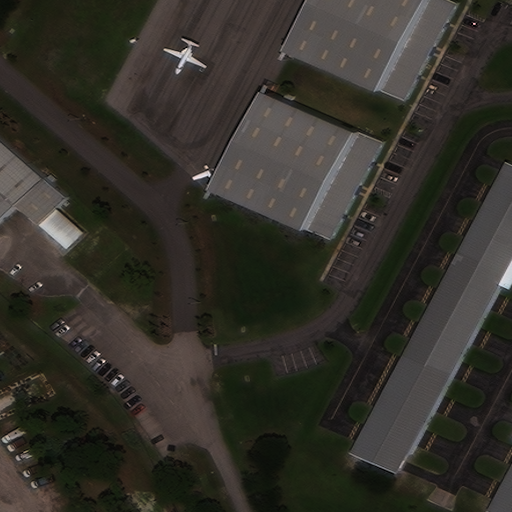

image_tile_id                             98_104001000F15D300_tile_177
image_id                                           98_104001000F15D300
loc_id                                                              98
Country                                                            USA
State_Province                                                 Florida
Air_Field                                                 Witham Field
Latitude                                                     27.183153
Longitude                                                   -80.224886
Weather                                                    Clear Skies
Time_of_Day                                                        Day
Hour_of_Day                                                      12.05
Season                                                          Summer
avg_sun_elevation_angle                                      67.557785
off_nadir_max                                                20.748598
avg_pa

In [7]:
# RarePlanes: Sample and its metadata
from PIL import Image

img_98_104001000F15D300_tile_177 = Image.open(
    os.path.join("../resources/98_104001000F15D300_tile_177.png")
)
rareplanes_df = pd.read_csv(
    os.path.join(
        "rareplanes_demo",
        "metadata",
        "RarePlanes_Metadata_Augmented_Processed_localized-tiled-controlpt-d01-full_resampled.csv",
    )
)
rareplanes_df.index = rareplanes_df.image_tile_id
display(img_98_104001000F15D300_tile_177)
display(rareplanes_df.loc["98_104001000F15D300_tile_177"])

### 1a) Combinatorial coverage over a defined universe



In [8]:
# Dataset
rareplanes_df.head(n=5)

,image_tile_id,image_id,loc_id,Country,State_Province,Air_Field,Latitude,Longitude,Weather,Time_of_Day,Hour_of_Day,Season,avg_sun_elevation_angle,off_nadir_max,avg_pan_resolution,biome,realm,CONTROL
image_tile_id,,,,,,,,,,,,,,,,,,
81_1040010036B67400_tile_326,81_1040010036B67400_tile_326,81_1040010036B67400,81,USA,New York,Albany International Airport,42.748016,-73.798556,Snow,Day,11.316667,Winter,24.195606,26.440168,0.371785,Temperate Broadleaf & Mixed Forests,Nearctic,2
24_104001002299DB00_tile_150,24_104001002299DB00_tile_150,24_104001002299DB00,24,Lithuania,Vilnius,Vilnius International Airport,54.634836,25.290314,Clear Skies,Day,13.166667,Autumn,39.400517,27.427486,0.379628,Temperate Broadleaf & Mixed Forests,Palearctic,3
86_1040010049B46C00_tile_272,86_1040010049B46C00_tile_272,86_1040010049B46C00,86,USA,Florida,Palm Beach International Airport,26.685948,-80.092487,Cloud Cover or Haze,Day,12.183333,Spring,54.206795,28.062920,0.377690,Flooded Grasslands & Savannas,Neotropic,3
59_104001001DC7F200_tile_1085,59_104001001DC7F200_tile_1085,59_104001001DC7F200,59,Brazil,Rio de Janeiro South East Region,Tom Jobim International Airport,-22.811306,-43.257476,Clear Skies,Day,10.266667,Autumn,42.501724,24.725229,0.367966,Tropical & Subtropical Moist Broadleaf Forests,Neotropic,2
115_10400100067A5900_tile_645,115_10400100067A5900_tile_645,115_10400100067A5900,115,USA,Alabama,Birmingham-Shuttlesworth International Airport,33.563501,-86.751516,Clear Skies,Day,10.566667,Winter,31.546478,28.385544,0.387907,Temperate Broadleaf & Mixed Forests,Nearctic,3


In [9]:
# Binning file, binned dataset
display_binning_file(os.path.join("rareplanes_demo", "binning", "bins-signif.txt"))

Hour_of_Day: [10.26,11.27);[11.27,12.28);[12.28,13.29);[13.29,14.3);[14.3,15.32]
avg_pan_resolution: (0.31,0.3419495);[0.3419495,0.3729495];(0.3729495,0.41]
biome: Temperate Grasslands, Savannas & Shrublands;Temperate Broadleaf & Mixed Forests;Temperate Conifer Forests;Boreal Forests/Taiga;Flooded Grasslands & Savannas;Deserts & Xeric Shrublands;Mediterranean Forests, Woodlands & Scrub;Mangroves;Tropical & Subtropical Moist Broadleaf Forests;Tropical & Subtropical Coniferous Forests;Tropical & Subtropical Grasslands, Savannas & Shrublands;Tundra


In [10]:
input_cc_train1 = load_json(
    os.path.join("rareplanes_demo", "configs", "cc_train1.json")
)
universe, rareplanes_df_binned = codex.universe_handler.define_input_space(
    input_cc_train1
)

# rareplanes_df_binned = pd.read_csv(os.path.join('rareplanes_demo', 'metadata', 'RarePlanes_Metadata_Augmented_Processed_localized-tiled-controlpt-d01-full_resampled_Binned.csv'))
display(rareplanes_df_binned.head())
display(universe)

,image_tile_id,Hour_of_Day,avg_pan_resolution,biome
0,78_10400100351F9900_tile_126,"[12.28,13.29)","(0.3729495,0.41]","Temperate Grasslands, Savannas & Shrublands"
1,118_104001000A341F00_tile_540,"[11.27,12.28)","[0.3419495,0.3729495]","Temperate Grasslands, Savannas & Shrublands"
2,39_104001001D4E6100_tile_473,"[12.28,13.29)","(0.31,0.3419495)","Temperate Grasslands, Savannas & Shrublands"
3,118_1040010023C25400_tile_729,"[11.27,12.28)","(0.31,0.3419495)","Temperate Grasslands, Savannas & Shrublands"
4,130_104001002E47CD00_tile_1278,"[11.27,12.28)","(0.3729495,0.41]","Temperate Grasslands, Savannas & Shrublands"


{'features': ['Hour_of_Day', 'avg_pan_resolution', 'biome'],
 'levels': [['[10.26,11.27)',
   '[11.27,12.28)',
   '[12.28,13.29)',
   '[13.29,14.3)',
   '[14.3,15.32]'],
  ['(0.31,0.3419495)', '[0.3419495,0.3729495]', '(0.3729495,0.41]'],
  ['Temperate Grasslands, Savannas & Shrublands',
   'Temperate Broadleaf & Mixed Forests',
   'Temperate Conifer Forests',
   'Boreal Forests/Taiga',
   'Flooded Grasslands & Savannas',
   'Deserts & Xeric Shrublands',
   'Mediterranean Forests, Woodlands & Scrub',
   'Mangroves',
   'Tropical & Subtropical Moist Broadleaf Forests',
   'Tropical & Subtropical Coniferous Forests',
   'Tropical & Subtropical Grasslands, Savannas & Shrublands',
   'Tundra']]}

In [11]:
# Input file
input_cc_train1 = load_json(
    os.path.join("rareplanes_demo", "configs", "cc_train1.json")
)
display(codex.output.output_json_readable(input_cc_train1))

{'mode': 'dataset evaluation',
 'dataset_name': 'RarePlanes',
 'model_name': 'YOLOv8l',
 'codex_directory': 'rareplanes_demo/',
 'config_id': 'demo_1-coverage_train1',
 'build_new_codex_directory*': '',
 'timed_output': False,
 'data_directory': 'metadata/',
 'dataset_file': 'RarePlanes_Metadata_Augmented_Processed_localized-tiled-controlpt-d01-train1.csv',
 'features': ['Hour_of_Day', 'avg_pan_resolution', 'biome'],
 'bin_file': 'binning/bins-signif.txt',
 'sample_id_column': 'image_tile_id',
 'universe': None,
 'use_augmented_universe': False,
 'counting_mode': 'label_exclusive',
 't': [1, 2, 3],
 'split_folder': '',
 'split_file': '',
 'performance_folder': 'performance',
 'performance_file': 'performance_trn1.json',
 'metric': '',
 'subset': None}

### 1b) Run dataset evaluation on different datasets
From the overall dataset:
- Withhold a randomly sampled test set from the RarePlanes overall dataset first
    - Size: 215 samples
- Construct a training set with artificially low coverage, train1
    - By including only samples captured in "Temperate Grasslands, Savannas & Shrublands" biomes
    - Size: 1,217 samples
- Construct a training set with moderate coverage by randomly sampling from remaining samples, train2
    - Size: 1,217 samples

In [12]:
# Run CODEX
train1_coverage = codex.run(input_cc_train1, verbose="1")

Results saved to /home/hume-users/leebri2n/PROJECTS/dote_1070-1083/CODEX/examples/rareplanes_demo/demo_1-coverage_train1.


In [13]:
# JSON results: combinatorial coverage: __demo__/rareplanes_demo/demo_1-coverage_train1/coverage.json
display(train1_coverage)
train1_cc = cc_results_t("Train 1", train1_coverage, "CC", [1, 2, 3])

{'info': {'dataset name': 'RarePlanes', 'model name': 'YOLOv8l'},
 'universe': {'features': ['Hour_of_Day', 'avg_pan_resolution', 'biome'],
  'levels': [['[10.26,11.27)',
    '[11.27,12.28)',
    '[12.28,13.29)',
    '[13.29,14.3)',
    '[14.3,15.32]'],
   ['(0.31,0.3419495)', '[0.3419495,0.3729495]', '(0.3729495,0.41]'],
   ['Temperate Grasslands, Savannas & Shrublands',
    'Temperate Broadleaf & Mixed Forests',
    'Temperate Conifer Forests',
    'Boreal Forests/Taiga',
    'Flooded Grasslands & Savannas',
    'Deserts & Xeric Shrublands',
    'Mediterranean Forests, Woodlands & Scrub',
    'Mangroves',
    'Tropical & Subtropical Moist Broadleaf Forests',
    'Tropical & Subtropical Coniferous Forests',
    'Tropical & Subtropical Grasslands, Savannas & Shrublands',
    'Tundra']]},
 'mode': 'dataset evaluation',
 1: {'count appearing interactions': 7,
  'total possible interactions': 20,
  'CC': 0.35,
  'combinations': ['Hour_of_Day', 'avg_pan_resolution', 'biome'],
  'combinatio

dict_keys(['info', 'universe', 'mode', 1, 2, 3])
Train 1 | CC for 1-way interactions: 0.35
Train 1 | CC for 2-way interactions: 0.13513513513513514
Train 1 | CC for 3-way interactions: 0.05



In [14]:
# JSON results: missing interactions: __demo__/rareplanes_demo/demo_1-coverage_train1/coverage.json
# TRY other result contents: ['count appearing interactions', 'total possible interactions', 'combinations', 'combination counts']
element = "missing interactions"
cc_results_t("Train 1", coverage=train1_coverage, element=element, strengths=[1, 2, 3])

dict_keys(['info', 'universe', 'mode', 1, 2, 3])
Train 1 | missing interactions for 1-way interactions: [[('Hour_of_Day', '[13.29,14.3)')], [('Hour_of_Day', '[14.3,15.32]')], [('biome', 'Temperate Broadleaf & Mixed Forests')], [('biome', 'Temperate Conifer Forests')], [('biome', 'Boreal Forests/Taiga')], [('biome', 'Flooded Grasslands & Savannas')], [('biome', 'Deserts & Xeric Shrublands')], [('biome', 'Mediterranean Forests, Woodlands & Scrub')], [('biome', 'Mangroves')], [('biome', 'Tropical & Subtropical Moist Broadleaf Forests')], [('biome', 'Tropical & Subtropical Coniferous Forests')], [('biome', 'Tropical & Subtropical Grasslands, Savannas & Shrublands')], [('biome', 'Tundra')]]
Train 1 | missing interactions for 2-way interactions: [[('Hour_of_Day', '[13.29,14.3)'), ('avg_pan_resolution', '(0.31,0.3419495)')], [('Hour_of_Day', '[14.3,15.32]'), ('avg_pan_resolution', '(0.31,0.3419495)')], [('Hour_of_Day', '[13.29,14.3)'), ('avg_pan_resolution', '[0.3419495,0.3729495]')], [('Hour

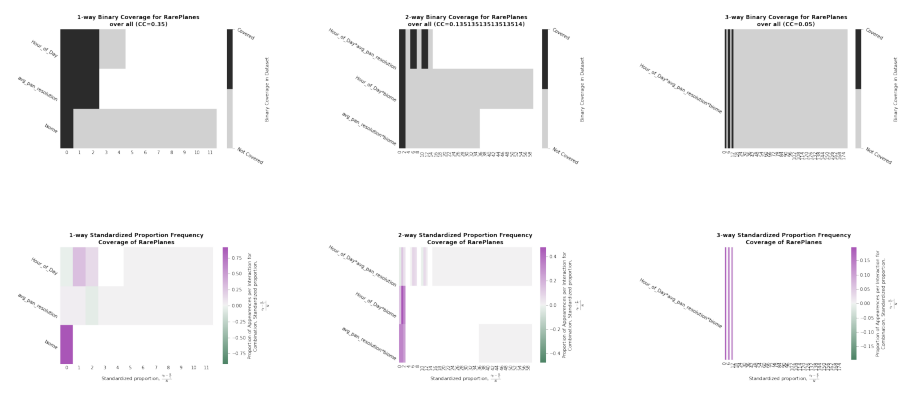

In [15]:
# Visualization results: __demo__/rareplanes_demo/demo_1-coverage_train1/CC/
visualize_cc(input_cc_train1)

In [16]:
# Train 2: Load, run, results
input_cc_train2 = load_json(
    os.path.join("rareplanes_demo", "configs", "cc_train2.json")
)
display(input_cc_train2)
# Note that the config_id and dataset fields have changed

{'mode': 'dataset evaluation',
 'dataset_name': 'RarePlanes',
 'model_name': 'YOLOv8l',
 'codex_directory': 'rareplanes_demo/',
 'config_id': 'demo_1-coverage_train2',
 'build_new_codex_directory*': '',
 'timed_output': False,
 'data_directory': 'metadata/',
 'dataset_file': 'RarePlanes_Metadata_Augmented_Processed_localized-tiled-controlpt-d01-train2.csv',
 'features': ['Hour_of_Day', 'avg_pan_resolution', 'biome'],
 'bin_file': 'binning/bins-signif.txt',
 'sample_id_column': 'image_tile_id',
 'universe': None,
 'use_augmented_universe': False,
 'counting_mode': 'label_exclusive',
 't': [1, 2, 3],
 'split_folder': '',
 'split_file': '',
 'performance_folder': '',
 'performance_file': 'performance_trn2.json',
 'metric': '',
 'subset': None}

Results saved to /home/hume-users/leebri2n/PROJECTS/dote_1070-1083/CODEX/examples/rareplanes_demo/demo_1-coverage_train2.
dict_keys(['info', 'universe', 'mode', 1, 2, 3])
Train 2 | CC for 1-way interactions: 1.0
Train 2 | CC for 2-way interactions: 0.6936936936936937
Train 2 | CC for 3-way interactions: 0.37222222222222223



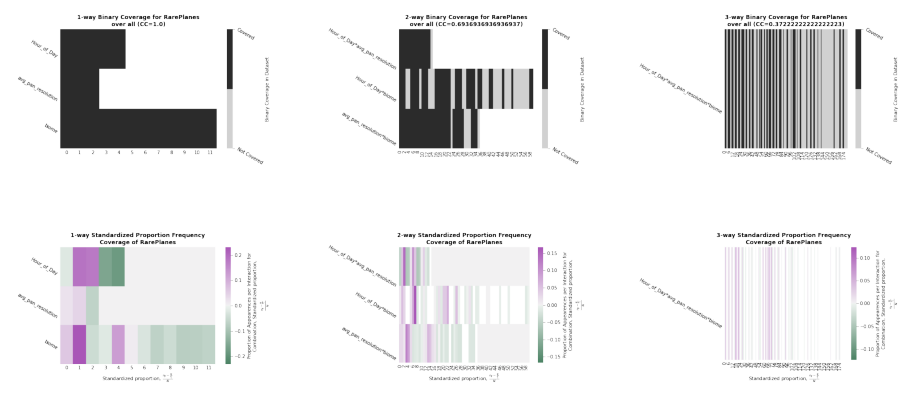

In [17]:
train2_coverage = codex.run(input_cc_train2, verbose="1")
cc_results_t("Train 2", train2_coverage, "CC", [1, 2, 3])
visualize_cc(input_cc_train2)

Results saved to /home/hume-users/leebri2n/PROJECTS/dote_1070-1083/CODEX/examples/rareplanes_demo/demo_1-coverage_test12.
dict_keys(['info', 'universe', 'mode', 1, 2, 3])
Test12 | CC for 1-way interactions: 1.0
Test12 | CC for 2-way interactions: 0.6126126126126126
Test12 | CC for 3-way interactions: 0.26666666666666666



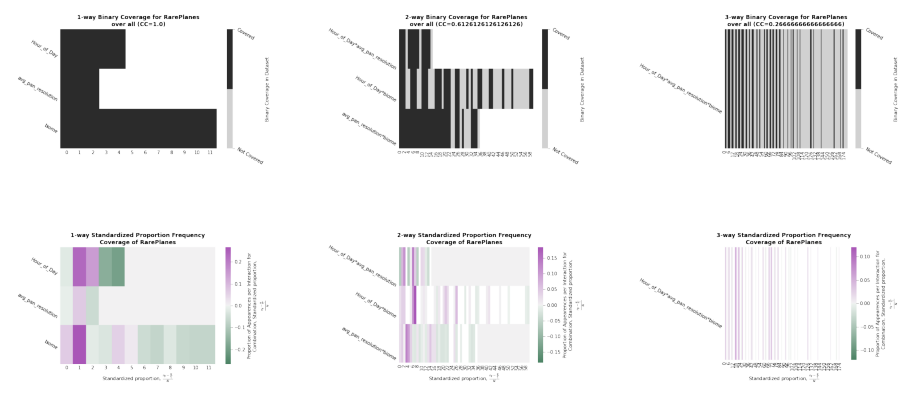

In [18]:
# Test12: Load, run, results
input_cc_test12 = load_json(
    os.path.join("rareplanes_demo", "configs", "cc_test12.json")
)
test12_coverage = codex.run(input_cc_test12, verbose="1")
cc_results_t("Test12", test12_coverage, "CC", [1, 2, 3])
visualize_cc(input_cc_test12)

- Dataset evaluation allows the user to test **how completely the dataset covers that input space.**

### 1c) Model performance and dataset evaluation
Furthermore, depending on how the universe is defined, combinatorial coverage over the universe resulting from dataset evaluation can be correlated with model performance. If a universe describes the operating envelope poorly, CC is misleading.

Obtaining model evaluations for a model trained on train1...
Performance of model trained on train1 (CC_2: 0.135) and evaluated on test12 (CC_2: 0.613):
{
    "tp": 475,
    "fp": 93,
    "fn": 190,
    "predictions": 568,
    "ground truth": 665,
    "precision": 0.8362676056338029,
    "recall": 0.7142857142857143,
    "f1": 0.7704785077047851
}
Obtaining model evaluations for a model trained on train2...
Performance of model trained on train2 (CC_2: 0.694) and evaluated on test12 (CC_2: 0.613):
{
    "tp": 543,
    "fp": 74,
    "fn": 122,
    "predictions": 617,
    "ground truth": 665,
    "precision": 0.880064829821718,
    "recall": 0.8165413533834587,
    "f1": 0.8471138845553822
}


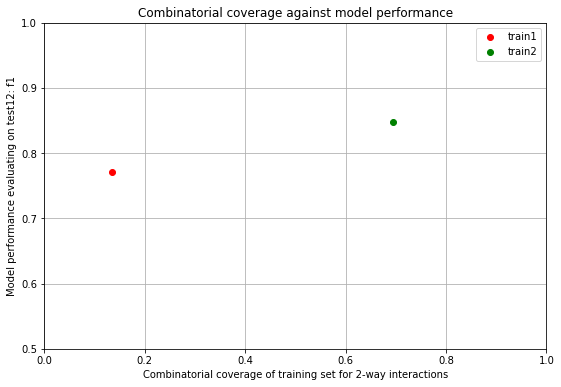

In [19]:
# CC of training set vs. model performance
# SELECT metric: [precision, recall, f1]
metric = "f1"
performance_train1 = model_performance(
    "train1",
    "test12",
    input_cc_train1,
    input_cc_test12,
    train1_coverage,
    test12_coverage,
    metric=metric,
)
performance_train2 = model_performance(
    "train2",
    "test12",
    input_cc_train2,
    input_cc_test12,
    train2_coverage,
    test12_coverage,
    metric=metric,
)

differential_performance_cc(
    train1_coverage, train2_coverage, performance_train1, performance_train2, metric, 2
)

From this example with this particular defined universe, higher coverage over the universe is correlated with higher model performance. Depending on the formulation of the particular operating envelope, coverage can be a helpful metric of performance but also a helpful predictor of performance.

This example demonstrates the capability of dataset evaluation. Dataset evaluation enables a user to characterize how complete a dataset is over a defined universe. In this case, the test set, as is the train2 set, is relatively complete over the defined universe. However, there likely exist scenarios in which the model operates in an environment that is unlike the complete universe. Because of this, there is a need to characterize the relationship between two sets of data that may have different envelopes, as can be the case when datasets are split into training and test sets.

### 1d) Try: Bin adjustment

Navigating to 'rareplanes_demo/binning/bins-signif.txt', try re-adjusting a bins of continuous variables to reconstruct the universe and reeavluate the dataset.

**Note: Bins should cover all values between the minimum and the maximum of each feature.** Run the following cells afterward.

In [20]:
display_binning_file(os.path.join("rareplanes_demo", "binning", "bins-edit.txt"))

Hour_of_Day: [10.26,11.27);[11.27,12.28);[12.28,13.29);[13.29,14.3);[14.3,15.32]
avg_pan_resolution: (0.31,0.3419495);[0.3419495,0.3729495];(0.3729495,0.41]
biome: Temperate Grasslands, Savannas & Shrublands;Temperate Broadleaf & Mixed Forests;Temperate Conifer Forests;Boreal Forests/Taiga;Flooded Grasslands & Savannas;Deserts & Xeric Shrublands;Mediterranean Forests, Woodlands & Scrub;Mangroves;Tropical & Subtropical Moist Broadleaf Forests;Tropical & Subtropical Coniferous Forests;Tropical & Subtropical Grasslands, Savannas & Shrublands;Tundra


Results saved to /home/hume-users/leebri2n/PROJECTS/dote_1070-1083/CODEX/examples/rareplanes_demo/demo_1-coverage_train1.
dict_keys(['info', 'universe', 'mode', 1, 2, 3])
Train 1, bins readjusted: | CC for 1-way interactions: 0.35
Train 1, bins readjusted: | CC for 2-way interactions: 0.13513513513513514
Train 1, bins readjusted: | CC for 3-way interactions: 0.05



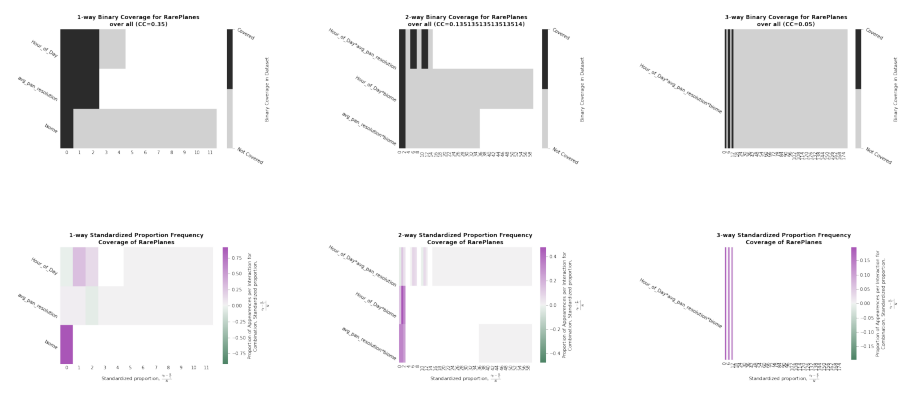

In [21]:
input_cc_train1 = load_json(
    os.path.join("rareplanes_demo", "configs", "cc_train1.json")
)
input_cc_train1["bin_file"] = "binning/bins-edit.txt"
results_cc_train1 = codex.run(input_cc_train1, verbose="1")
cc_results_t("Train 1, bins readjusted:", results_cc_train1, "CC", [1, 2, 3])
visualize_cc(input_cc_train1)

# 2) Dataset Split Evaluation
"Dataset split evaluation" computes set difference combinatorial coverage (SDCC) between training, validation, and test datasets.

*"How do I characterize the difference and distance between training/validation/testing splits of my dataset?"*

### Differing operating envelopes
For simplicity, consider two completely separate regions, A and B, of the RarePlanes dataset. These regions might exist as the different operating envelopes environments a model is deployed in:
- Region A was constructed by selecting samples containing the three 2-way interactions of level 1 of the Hour_of_Day metadata feature and levels 1, 2, and 3 of the avg_pan_resolution metadata feature.
    - Samples containing h1\*p1, h1\*p2, h1\*p3
- Region B was constructed by selecting samples containing the three 2-way interactions of level 2 of the Hour_of_Day metadata feature and levels 1, 2, and 3 of the avg_pan_resolution metadata feature.
    - Samples containing h2\*p1, h2\*p2, h2\*p3
- size(regionA) = size(regionB)

Because of this construction, A and B are disjoint in 2-way interactions and therefore disjoint in samples at the 3-way interaction level as well as being disjoint in their samples.

In each separate region, training and testing **splits** are constructed by random sampling.
- trainA, testA is randomly sampled 85-15.
- trainB, testB is randomly sampled 85-15.

### Dataset splits)
Dataset splits are leveraged by CODEX in the form of split files to compute CC values of splits and SDCC values between splits. 

CODEX supports split files in specific JSON format to select samples for each split.
- Lists under keys designating the sample names belonging to each split as they appear in the dataset ('train', 'validation', 'test')
- Split ID for user record

In [22]:
display_split_file(os.path.join("rareplanes_demo", "splits", "split_AB_combined.json"))

['split_id', 'regionA', 'regionB', 'trainA', 'testA', 'trainB', 'testB']

{'split_id': 'split_34',
 'regionA': ['6_104001003153D300_tile_348',
  '78_10400100351F9900_tile_126',
  '35_104005000ADCB500_tile_111',
  '8_104001001051CB00_tile_70',
  '18_10400100211BDD00_tile_3027',
  '...'],
 'regionB': ['127_104001002B3BB400_tile_775',
  '45_104001000E6AB500_tile_24',
  '67_1040010046D15B00_tile_904',
  '20_1040010038CAE700_tile_123',
  '93_104001002A4FAA00_tile_1202',
  '...'],
 'trainA': ['106_1040010044D30600_tile_111',
  '77_104001004299B200_tile_866',
  '77_104001004299B200_tile_731',
  '86_104001003D8DB300_tile_111',
  '106_10400100413CDF00_tile_60',
  '...'],
 'testA': ['6_104001003153D300_tile_348',
  '13_104001001A99E200_tile_29',
  '100_1040010029990A00_tile_333',
  '67_104001003F0B3200_tile_682',
  '45_1040010044AFF200_tile_44',
  '...'],
 'trainB': ['84_1040010049B46C00_tile_231',
  '4_1040010019345B00_tile_767',
  '82_10400100435D3500_tile_403',
  '127_104001002B3BB400_tile_443',
  '96_104001000896F900_tile_884',
  '...'],
 'testB': ['20_1040010038C

In [23]:
# Load and view splits of sample ID's provided in file
splits_ab = load_json(
    os.path.join("rareplanes_demo", "splits", "split_AB_combined.json")
)

trainA_ids = splits_ab["trainA"]
testA_ids = splits_ab["testA"]
trainB_ids = splits_ab["trainB"]
testB_ids = splits_ab["testB"]
print("{} samples in train A: {}".format(len(trainA_ids), trainA_ids[:2] + ["..."]))
print("{} samples in test A: {}".format(len(testA_ids), testA_ids[:2] + ["..."]))
print("")
print("{} samples in train B: {}".format(len(trainB_ids), trainB_ids[:2] + ["..."]))
print("{} samples in test B: {}".format(len(testB_ids), testB_ids[:2] + ["..."]))
print("")
intersection = split_intersection(trainA_ids, testA_ids)

2682 samples in train A: ['106_1040010044D30600_tile_111', '77_104001004299B200_tile_866', '...']
474 samples in test A: ['6_104001003153D300_tile_348', '13_104001001A99E200_tile_29', '...']

2682 samples in train B: ['84_1040010049B46C00_tile_231', '4_1040010019345B00_tile_767', '...']
474 samples in test B: ['20_1040010038CAE700_tile_123', '118_1040010023C25400_tile_729', '...']

The intersection of the splits contain 0 entries.


### 2a) Dataset Split Evaluation: Similar Operating Envelopes

In [24]:
# Dataset
rareplanes_df = pd.read_csv(
    os.path.join(
        "rareplanes_demo",
        "metadata",
        "RarePlanes_Metadata_Augmented_Processed_localized-tiled-controlpt-d01-full_resampled.csv",
    )
)
display(rareplanes_df.head())

,image_tile_id,image_id,loc_id,Country,State_Province,Air_Field,Latitude,Longitude,Weather,Time_of_Day,Hour_of_Day,Season,avg_sun_elevation_angle,off_nadir_max,avg_pan_resolution,biome,realm,CONTROL
0,81_1040010036B67400_tile_326,81_1040010036B67400,81,USA,New York,Albany International Airport,42.748016,-73.798556,Snow,Day,11.316667,Winter,24.195606,26.440168,0.371785,Temperate Broadleaf & Mixed Forests,Nearctic,2
1,24_104001002299DB00_tile_150,24_104001002299DB00,24,Lithuania,Vilnius,Vilnius International Airport,54.634836,25.290314,Clear Skies,Day,13.166667,Autumn,39.400517,27.427486,0.379628,Temperate Broadleaf & Mixed Forests,Palearctic,3
2,86_1040010049B46C00_tile_272,86_1040010049B46C00,86,USA,Florida,Palm Beach International Airport,26.685948,-80.092487,Cloud Cover or Haze,Day,12.183333,Spring,54.206795,28.062920,0.377690,Flooded Grasslands & Savannas,Neotropic,3
3,59_104001001DC7F200_tile_1085,59_104001001DC7F200,59,Brazil,Rio de Janeiro South East Region,Tom Jobim International Airport,-22.811306,-43.257476,Clear Skies,Day,10.266667,Autumn,42.501724,24.725229,0.367966,Tropical & Subtropical Moist Broadleaf Forests,Neotropic,2
4,115_10400100067A5900_tile_645,115_10400100067A5900,115,USA,Alabama,Birmingham-Shuttlesworth International Airport,33.563501,-86.751516,Clear Skies,Day,10.566667,Winter,31.546478,28.385544,0.387907,Temperate Broadleaf & Mixed Forests,Nearctic,3


In [25]:
# Binning file, binned dataset
display_binning_file(os.path.join("rareplanes_demo", "binning", "bins-signif.txt"))

Hour_of_Day: [10.26,11.27);[11.27,12.28);[12.28,13.29);[13.29,14.3);[14.3,15.32]
avg_pan_resolution: (0.31,0.3419495);[0.3419495,0.3729495];(0.3729495,0.41]
biome: Temperate Grasslands, Savannas & Shrublands;Temperate Broadleaf & Mixed Forests;Temperate Conifer Forests;Boreal Forests/Taiga;Flooded Grasslands & Savannas;Deserts & Xeric Shrublands;Mediterranean Forests, Woodlands & Scrub;Mangroves;Tropical & Subtropical Moist Broadleaf Forests;Tropical & Subtropical Coniferous Forests;Tropical & Subtropical Grasslands, Savannas & Shrublands;Tundra


In [26]:
# Universe and binned dataset
input_sdcc_tAeA = load_json(os.path.join("rareplanes_demo", "configs", "sdcc_A-A.json"))
universe, rareplanes_df_binned = codex.universe_handler.define_input_space(
    input_sdcc_tAeA
)
display(universe)
display(rareplanes_df_binned.head())

{'features': ['Hour_of_Day', 'avg_pan_resolution', 'biome'],
 'levels': [['[10.26,11.27)',
   '[11.27,12.28)',
   '[12.28,13.29)',
   '[13.29,14.3)',
   '[14.3,15.32]'],
  ['(0.31,0.3419495)', '[0.3419495,0.3729495]', '(0.3729495,0.41]'],
  ['Temperate Grasslands, Savannas & Shrublands',
   'Temperate Broadleaf & Mixed Forests',
   'Temperate Conifer Forests',
   'Boreal Forests/Taiga',
   'Flooded Grasslands & Savannas',
   'Deserts & Xeric Shrublands',
   'Mediterranean Forests, Woodlands & Scrub',
   'Mangroves',
   'Tropical & Subtropical Moist Broadleaf Forests',
   'Tropical & Subtropical Coniferous Forests',
   'Tropical & Subtropical Grasslands, Savannas & Shrublands',
   'Tundra']]}

,image_tile_id,Hour_of_Day,avg_pan_resolution,biome
0,6_104001003153D300_tile_348,"[12.28,13.29)","(0.31,0.3419495)",Temperate Broadleaf & Mixed Forests
1,78_10400100351F9900_tile_126,"[12.28,13.29)","(0.3729495,0.41]","Temperate Grasslands, Savannas & Shrublands"
2,35_104005000ADCB500_tile_111,"[12.28,13.29)","[0.3419495,0.3729495]",Temperate Broadleaf & Mixed Forests
3,8_104001001051CB00_tile_70,"[12.28,13.29)","(0.3729495,0.41]",Temperate Broadleaf & Mixed Forests
4,18_10400100211BDD00_tile_3027,"[12.28,13.29)","(0.31,0.3419495)",Temperate Broadleaf & Mixed Forests


In [27]:
# Load input files
input_sdcc_tAeA = load_json(os.path.join("rareplanes_demo", "configs", "sdcc_A-A.json"))
display(input_sdcc_tAeA)
input_sdcc_tBeB = load_json(os.path.join("rareplanes_demo", "configs", "sdcc_B-B.json"))
display(input_sdcc_tBeB)
# Note changes to the fields: mode, config_id, split_folder, split_file, source_tag, target_tag

{'mode': 'dataset split evaluation',
 'codex_directory': 'rareplanes_demo/',
 'config_id': 'runs/_demoexp-dataset_split_eval-trainA-testA',
 'dataset_name': 'RarePlanes',
 'model_name': 'YOLOv8n',
 'data_directory': 'metadata/',
 'dataset_file': 'RarePlanes_Metadata_Augmented_Processed_localized-tiled-controlpt-d02-regionAB.csv',
 'features': ['Hour_of_Day', 'avg_pan_resolution', 'biome'],
 'bin_file': 'binning/bins-signif.txt',
 'sample_id_column': 'image_tile_id',
 'universe': None,
 'use_augmented_universe': False,
 'counting_mode': 'label_exclusive',
 't': [1, 2, 3],
 'timed_output': False,
 'subset': '',
 'split_folder': 'splits/',
 'split_file': 'split_AB_combined.json',
 'source_name': 'trainA',
 'target_name': 'testA',
 'metric': None,
 'performance_folder': 'performance',
 'performance_file': 'performance_trnAevalA.json'}

{'mode': 'dataset split evaluation',
 'codex_directory': 'rareplanes_demo/',
 'config_id': 'runs/_demoexp-dataset_split_eval-trainB-testB',
 'dataset_name': 'RarePlanes',
 'model_name': 'YOLOv8n',
 'data_directory': 'metadata/',
 'dataset_file': 'RarePlanes_Metadata_Augmented_Processed_localized-tiled-controlpt-d02-regionAB.csv',
 'features': ['Hour_of_Day', 'avg_pan_resolution', 'biome'],
 'bin_file': 'binning/bins-signif.txt',
 'sample_id_column': 'image_tile_id',
 'universe': None,
 'use_augmented_universe': False,
 'counting_mode': 'label_exclusive',
 't': [1, 2, 3],
 'timed_output': False,
 'subset': '',
 'split_folder': 'splits/',
 'split_file': 'split_AB_combined.json',
 'source_name': 'trainB',
 'target_name': 'testB',
 'metric': None,
 'performance_folder': None,
 'performance_file': None}

In [28]:
# SDCC within region A
results_sdcc_tAeA = codex.run(input_sdcc_tAeA, verbose="1")

# Train interactions not in test
sdcc_results_t("A: train-test", results_sdcc_tAeA, "SDCC", [1, 2, 3], "trainA-testA")
# Test interactions not in train
sdcc_results_t("A: test-train", results_sdcc_tAeA, "SDCC", [1, 2, 3], "testA-trainA")

Results saved to /home/hume-users/leebri2n/PROJECTS/dote_1070-1083/CODEX/examples/rareplanes_demo/runs/_demoexp-dataset_split_eval-trainA-testA.
dict_keys(['info', 'universe', 'mode', 'split_id', 1, 2, 3])
A: train-test SDCC over 1-way interactions: 0.0
A: train-test SDCC over 2-way interactions: 0.0
A: train-test SDCC over 3-way interactions: 0.0

dict_keys(['info', 'universe', 'mode', 'split_id', 1, 2, 3])
A: test-train SDCC over 1-way interactions: 0.0
A: test-train SDCC over 2-way interactions: 0.0
A: test-train SDCC over 3-way interactions: 0.0



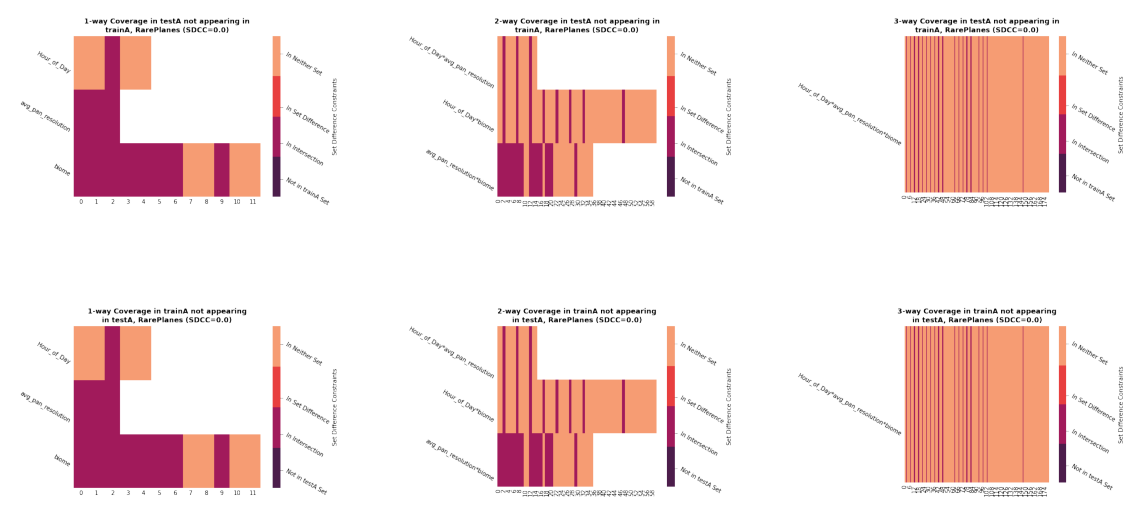

In [29]:
visualize_sdcc(input_sdcc_tAeA)

In [30]:
# SDCC within region B
results_sdcc_tBeB = codex.run(input_sdcc_tBeB, verbose="1")

# Train interactions not in test
sdcc_results_t("B: train-test", results_sdcc_tBeB, "SDCC", [1, 2, 3], "trainB-testB")
# Test interactions not in train
sdcc_results_t("B: test-train", results_sdcc_tBeB, "SDCC", [1, 2, 3], "testB-trainB")

Results saved to /home/hume-users/leebri2n/PROJECTS/dote_1070-1083/CODEX/examples/rareplanes_demo/runs/_demoexp-dataset_split_eval-trainB-testB.
dict_keys(['info', 'universe', 'mode', 'split_id', 1, 2, 3])
B: train-test SDCC over 1-way interactions: 0.0
B: train-test SDCC over 2-way interactions: 0.0
B: train-test SDCC over 3-way interactions: 0.0

dict_keys(['info', 'universe', 'mode', 'split_id', 1, 2, 3])
B: test-train SDCC over 1-way interactions: 0.0
B: test-train SDCC over 2-way interactions: 0.0
B: test-train SDCC over 3-way interactions: 0.0



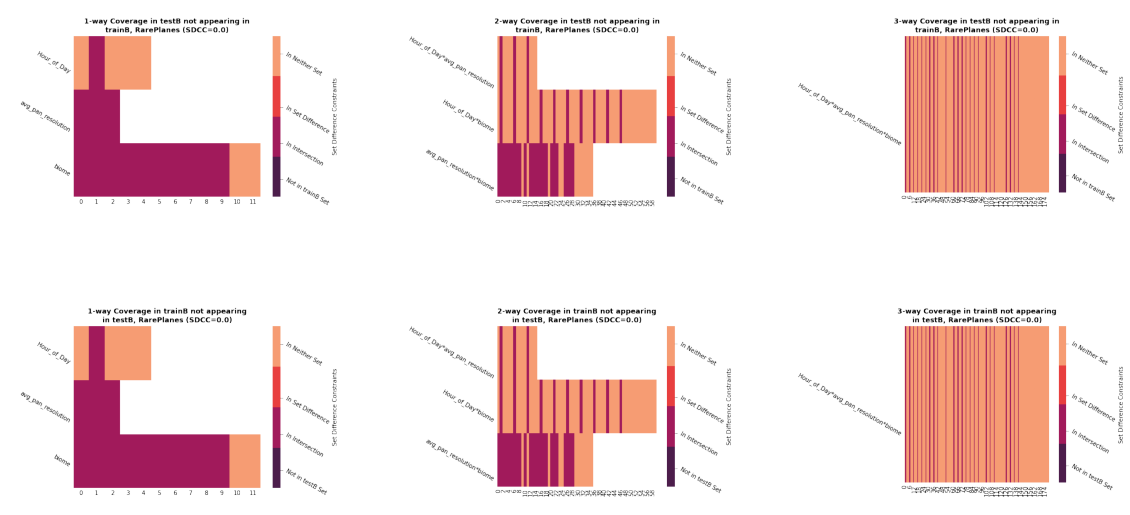

In [31]:
visualize_sdcc(input_sdcc_tBeB)

For both region A and region B, every interaction appearing in the test set appears in the training set, and every interaction appearing in the trianing set appears in the test set.

### 2b) Dataset Split Evaluation: Differing Operating Envelopes

In [32]:
# Load input files
input_sdcc_tAeB = load_json(
    os.path.join("rareplanes_demo", "configs", "sdcc_trnA-testB.json")
)
input_sdcc_tBeA = load_json(
    os.path.join("rareplanes_demo", "configs", "sdcc_trnB-testA.json")
)

In [33]:
# Dataset split comparison across regions
results_sdcc_tAeB = codex.run(input_sdcc_tAeB, verbose="1")

# Train interactions not in test
sdcc_results_t(
    "Train A, test B: train-test", results_sdcc_tAeB, "SDCC", [1, 2, 3], "trainA-testB"
)
# Test interactions not in train
sdcc_results_t(
    "Train A, test B: test-train", results_sdcc_tAeB, "SDCC", [1, 2, 3], "testB-trainA"
)

Results saved to /home/hume-users/leebri2n/PROJECTS/dote_1070-1083/CODEX/examples/rareplanes_demo/runs/_demoexp-dataset_split_eval-trainA-testB.
dict_keys(['info', 'universe', 'mode', 'split_id', 1, 2, 3])
Train A, test B: train-test SDCC over 1-way interactions: 0.08333333333333333
Train A, test B: train-test SDCC over 2-way interactions: 0.4666666666666667
Train A, test B: train-test SDCC over 3-way interactions: 1.0

dict_keys(['info', 'universe', 'mode', 'split_id', 1, 2, 3])
Train A, test B: test-train SDCC over 1-way interactions: 0.21428571428571427
Train A, test B: test-train SDCC over 2-way interactions: 0.5675675675675675
Train A, test B: test-train SDCC over 3-way interactions: 1.0



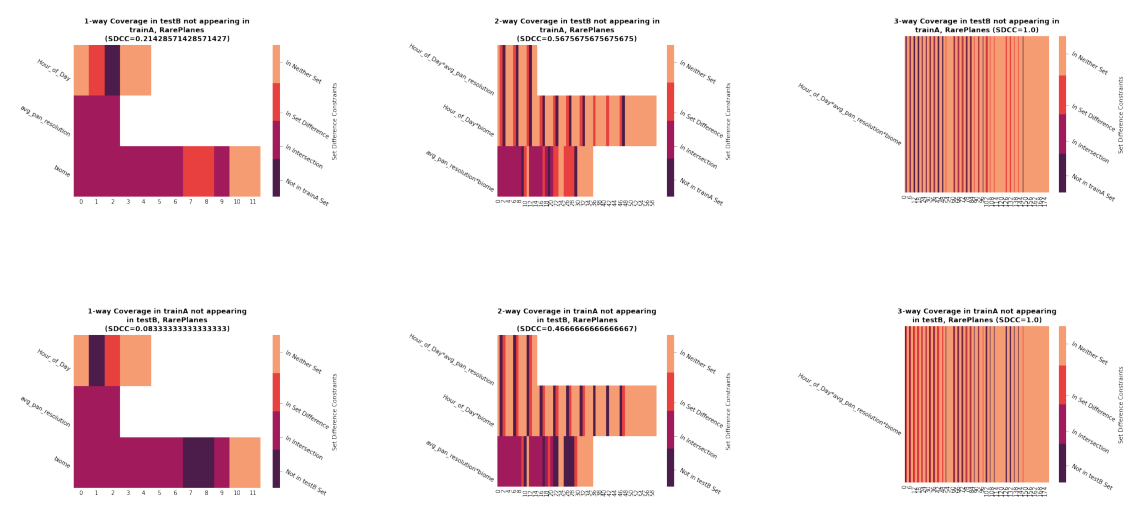

In [34]:
visualize_sdcc(input_sdcc_tAeB)

In [35]:
# Dataset split comparison across regions
results_sdcc_tBeA = codex.run(input_sdcc_tBeA, verbose="1")

# Train interactions not in test
sdcc_results_t(
    "Train B, test A: train-test", results_sdcc_tBeA, "SDCC", [1, 2, 3], "trainB-testA"
)
# Test interactions not in train
sdcc_results_t(
    "Train B, test A: test-train", results_sdcc_tBeA, "SDCC", [1, 2, 3], "testA-trainB"
)

Results saved to /home/hume-users/leebri2n/PROJECTS/dote_1070-1083/CODEX/examples/rareplanes_demo/runs/_demoexp-dataset_split_eval-trainB-testA.
dict_keys(['info', 'universe', 'mode', 'split_id', 1, 2, 3])
Train B, test A: train-test SDCC over 1-way interactions: 0.21428571428571427
Train B, test A: train-test SDCC over 2-way interactions: 0.5675675675675675
Train B, test A: train-test SDCC over 3-way interactions: 1.0

dict_keys(['info', 'universe', 'mode', 'split_id', 1, 2, 3])
Train B, test A: test-train SDCC over 1-way interactions: 0.08333333333333333
Train B, test A: test-train SDCC over 2-way interactions: 0.4666666666666667
Train B, test A: test-train SDCC over 3-way interactions: 1.0



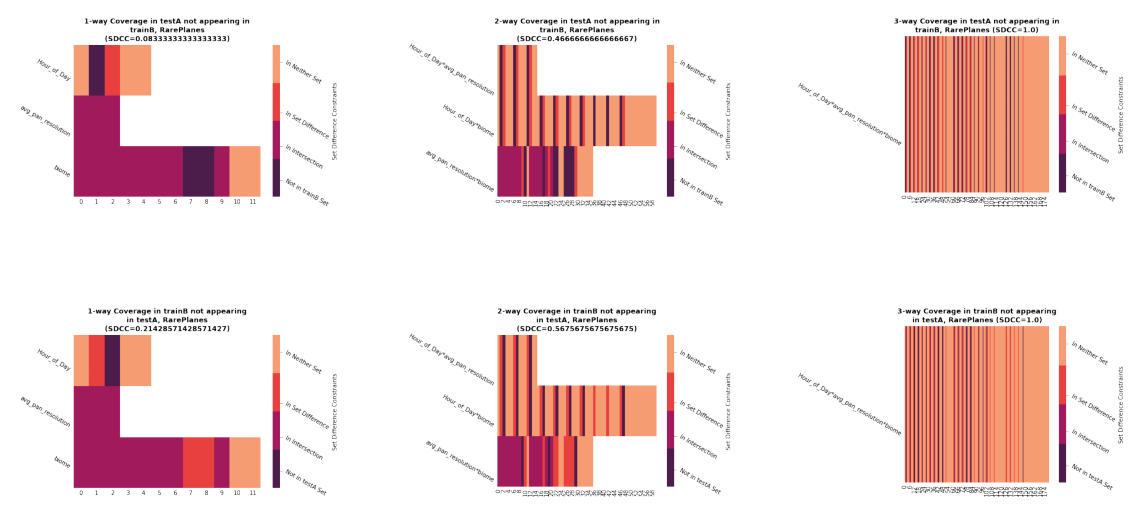

In [36]:
visualize_sdcc(input_sdcc_tBeA)

### 2c) Dataset split evaluation and model performance
Assuming or knowing that the model performs well over the entire defined universe, SDCC that results from dataset split evaluation can be a predictor of how a model will perform given its difference from the operating envelope of the training set.

In [37]:
# SDCC of training set vs. model performance
# SELECT metric: [precision, recall, f1]
metric = "f1"
performance_trainAA = model_performance_sdcc(
    "testA", "trainA", input_sdcc_tAeA, metric=metric
)
performance_trainAB = model_performance_sdcc(
    "testB", "trainA", input_sdcc_tAeB, metric=metric
)

Obtaining model evaluations for a model trained on testA and evaluated on trainA...
{
    "tp": 1080,
    "fp": 74,
    "fn": 87,
    "predictions": 1154,
    "ground truth": 1167,
    "precision": 0.9358752166377816,
    "recall": 0.9254498714652957,
    "f1": 0.9306333476949591
}
Obtaining model evaluations for a model trained on testB and evaluated on trainA...
{
    "tp": 1107,
    "fp": 161,
    "fn": 357,
    "predictions": 1268,
    "ground truth": 1464,
    "precision": 0.8730283911671924,
    "recall": 0.7561475409836066,
    "f1": 0.8103953147877013
}


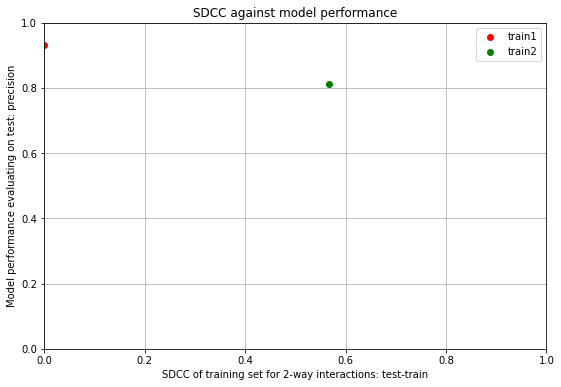

In [38]:
metric = "precision"  # [precision, f1, recall]
differential_performance_sdcc(
    results_sdcc_tAeA,
    results_sdcc_tAeB,
    "testA-trainA",
    "testB-trainA",
    performance_trainAA,
    performance_trainAB,
    metric,
    2,
)

When deployed outside of its operating envelope, model performance degrades.

# 3) Systematic Inclusion and Exclusion (SIE)

The SIE experiment aims to discover important combinations of features by systematically withholding each interaction from training and comparing a model's performance on one test set also withholding the interaction and one that contains only samples with said interaction.

*Beyond a feature-value level, what combinations of features and their interactions are most critical for the model to see in the dataset during training?*

In [39]:
# Dataset
rareplanes_df = pd.read_csv(
    os.path.join(
        "rareplanes_demo",
        "metadata",
        "RarePlanes_Metadata_Augmented_Processed_localized-tiled-controlpt-d01-full_resampled.csv",
    )
)
display(rareplanes_df.head())

,image_tile_id,image_id,loc_id,Country,State_Province,Air_Field,Latitude,Longitude,Weather,Time_of_Day,Hour_of_Day,Season,avg_sun_elevation_angle,off_nadir_max,avg_pan_resolution,biome,realm,CONTROL
0,81_1040010036B67400_tile_326,81_1040010036B67400,81,USA,New York,Albany International Airport,42.748016,-73.798556,Snow,Day,11.316667,Winter,24.195606,26.440168,0.371785,Temperate Broadleaf & Mixed Forests,Nearctic,2
1,24_104001002299DB00_tile_150,24_104001002299DB00,24,Lithuania,Vilnius,Vilnius International Airport,54.634836,25.290314,Clear Skies,Day,13.166667,Autumn,39.400517,27.427486,0.379628,Temperate Broadleaf & Mixed Forests,Palearctic,3
2,86_1040010049B46C00_tile_272,86_1040010049B46C00,86,USA,Florida,Palm Beach International Airport,26.685948,-80.092487,Cloud Cover or Haze,Day,12.183333,Spring,54.206795,28.062920,0.377690,Flooded Grasslands & Savannas,Neotropic,3
3,59_104001001DC7F200_tile_1085,59_104001001DC7F200,59,Brazil,Rio de Janeiro South East Region,Tom Jobim International Airport,-22.811306,-43.257476,Clear Skies,Day,10.266667,Autumn,42.501724,24.725229,0.367966,Tropical & Subtropical Moist Broadleaf Forests,Neotropic,2
4,115_10400100067A5900_tile_645,115_10400100067A5900,115,USA,Alabama,Birmingham-Shuttlesworth International Airport,33.563501,-86.751516,Clear Skies,Day,10.566667,Winter,31.546478,28.385544,0.387907,Temperate Broadleaf & Mixed Forests,Nearctic,3


In [40]:
# Binning file, binned dataset
display_binning_file(os.path.join("rareplanes_demo", "binning", "bins-complete.txt"))

Hour_of_Day: [10.26,11.27);[11.27,12.28);[12.28,13.29);[13.29,14.3);[14.3,15.32]
off_nadir_max: [3,12];(12,21];(21,30]
avg_pan_resolution: (0.31,0.3419495);[0.3419495,0.3729495];(0.3729495,0.41]
Season: Spring;Summer;Autumn;Winter
biome: Temperate Grasslands, Savannas & Shrublands;Temperate Broadleaf & Mixed Forests;Temperate Conifer Forests;Boreal Forests/Taiga;Flooded Grasslands & Savannas;Deserts & Xeric Shrublands;Mediterranean Forests, Woodlands & Scrub;Mangroves;Tropical & Subtropical Moist Broadleaf Forests;Tropical & Subtropical Coniferous Forests;Tropical & Subtropical Grasslands, Savannas & Shrublands;Tundra
CONTROL: 1;2;3


In [41]:
# Universe and binned dataset
input_sie = load_json(os.path.join("rareplanes_demo", "configs", "sie.json"))
universe, rareplanes_df_binned = codex.universe_handler.define_input_space(input_sie)
display(rareplanes_df_binned.head())
display(universe)

,image_tile_id,Hour_of_Day,Season,off_nadir_max,avg_pan_resolution,biome,CONTROL
0,127_104001002B3BB400_tile_775,"[11.27,12.28)",Spring,"[3,12]","(0.31,0.3419495)",Mangroves,1
1,45_104001000E6AB500_tile_24,"[11.27,12.28)",Summer,"(12,21]","(0.31,0.3419495)",Temperate Broadleaf & Mixed Forests,2
2,67_1040010046D15B00_tile_904,"[11.27,12.28)",Winter,"[3,12]","(0.31,0.3419495)",Deserts & Xeric Shrublands,3
3,126_104001000C4AEE00_tile_1325,"[10.26,11.27)",Summer,"(12,21]","[0.3419495,0.3729495]",Temperate Broadleaf & Mixed Forests,1
4,6_104001003153D300_tile_348,"[12.28,13.29)",Summer,"(12,21]","(0.31,0.3419495)",Temperate Broadleaf & Mixed Forests,2


{'features': ['Hour_of_Day',
  'off_nadir_max',
  'avg_pan_resolution',
  'Season',
  'biome',
  'CONTROL'],
 'levels': [['[10.26,11.27)',
   '[11.27,12.28)',
   '[12.28,13.29)',
   '[13.29,14.3)',
   '[14.3,15.32]'],
  ['[3,12]', '(12,21]', '(21,30]'],
  ['(0.31,0.3419495)', '[0.3419495,0.3729495]', '(0.3729495,0.41]'],
  ['Spring', 'Summer', 'Autumn', 'Winter'],
  ['Temperate Grasslands, Savannas & Shrublands',
   'Temperate Broadleaf & Mixed Forests',
   'Temperate Conifer Forests',
   'Boreal Forests/Taiga',
   'Flooded Grasslands & Savannas',
   'Deserts & Xeric Shrublands',
   'Mediterranean Forests, Woodlands & Scrub',
   'Mangroves',
   'Tropical & Subtropical Moist Broadleaf Forests',
   'Tropical & Subtropical Coniferous Forests',
   'Tropical & Subtropical Grasslands, Savannas & Shrublands',
   'Tundra'],
  ['1', '2', '3']]}

In [42]:
input_sie = load_json(os.path.join("rareplanes_demo", "configs", "sie.json"))
results = codex.run(input_sie, verbose="1")

print("Results contents:", list(results.keys()))

Generating splits excluding each 1-way interactions for combinations ['Hour_of_Day', 'Season', 'off_nadir_max', 'avg_pan_resolution', 'biome', 'CONTROL']...

Goal # samples per rank in test set:
 [20.0, 33.333333333333336, 33.333333333333336, 25.0, 8.333333333333334, 33.333333333333336] 

Frequencies of interactions:

INITIAL TESTCC
 {'t': 1, 'k': 6, 'kct': 6, 'representation': ['Hour_of_Day', 'off_nadir_max', 'avg_pan_resolution', 'Season', 'biome', 'CONTROL'], [['[10.26,11.27)', '[11.27,12.28)', '[12.28,13.29)', '[13.29,14.3)', '[14.3,15.32]'], ['[3,12]', '(12,21]', '(21,30]'], ['(0.31,0.3419495)', '[0.3419495,0.3729495]', '(0.3729495,0.41]'], ['Spring', 'Summer', 'Autumn', 'Winter'], ['Temperate Grasslands, Savannas & Shrublands', 'Temperate Broadleaf & Mixed Forests', 'Temperate Conifer Forests', 'Boreal Forests/Taiga', 'Flooded Grasslands & Savannas', 'Deserts & Xeric Shrublands', 'Mediterranean Forests, Woodlands & Scrub', 'Mangroves', 'Tropical & Subtropical Moist Broadleaf Fore

In [43]:
display_sie_train_set(input_sie, "Hour_of_Day", "[10.26,11.27)")

'TRAINING SET EXCLUDING Hour_of_Day: [10.26,11.27)'

,image_tile_id,Hour_of_Day,Season,off_nadir_max,avg_pan_resolution,biome,CONTROL
0,4_10400100360CD600_tile_737,"[11.27,12.28)",Winter,"(21,30]","(0.3729495,0.41]",Temperate Conifer Forests,3
1,96_104001000896F900_tile_1144,"[11.27,12.28)",Spring,"(21,30]","[0.3419495,0.3729495]",Boreal Forests/Taiga,2
2,77_104001004299B200_tile_855,"[12.28,13.29)",Autumn,"(12,21]","(0.31,0.3419495)",Temperate Broadleaf & Mixed Forests,3
3,128_1040010032BA9100_tile_1970,"[11.27,12.28)",Autumn,"(12,21]","[0.3419495,0.3729495]","Temperate Grasslands, Savannas & Shrublands",1
4,18_1040050010DC4900_tile_1852,"[11.27,12.28)",Winter,"(21,30]","[0.3419495,0.3729495]",Temperate Broadleaf & Mixed Forests,3


'TRAINING SET Hour_of_Day: [10.26,11.27) SAMPLES:'

,image_tile_id,Hour_of_Day,Season,off_nadir_max,avg_pan_resolution,biome,CONTROL


"No samples with 'Hour_of_Day', '[10.26,11.27)'."

In [44]:
display_sie_test_sets(input_sie, "Hour_of_Day", "[10.26,11.27)")

'TEST COVERED BY TRAINING SET (EXCLUDING Hour_of_Day: [10.26,11.27)):'

,image_tile_id,Hour_of_Day,Season,off_nadir_max,avg_pan_resolution,biome,CONTROL
0,88_1040010044AC1100_tile_251,"[14.3,15.32]",Autumn,"[3,12]","(0.31,0.3419495)",Tundra,3
1,87_10400100480E4300_tile_44,"[13.29,14.3)",Winter,"(12,21]","(0.31,0.3419495)",Tundra,3
2,23_104001001E51BE00_tile_1267,"[12.28,13.29)",Summer,"[3,12]","(0.31,0.3419495)","Mediterranean Forests, Woodlands & Scrub",3
3,87_10400100480E4300_tile_30,"[13.29,14.3)",Winter,"(12,21]","(0.31,0.3419495)",Tundra,3
4,88_1040010044AC1100_tile_380,"[14.3,15.32]",Autumn,"[3,12]","(0.31,0.3419495)",Tundra,2


"TEST NOT COVERED BY TRAINING SET (ALL SAMPLES' Hour_of_Day: [10.26,11.27)):"

,image_tile_id,Hour_of_Day,Season,off_nadir_max,avg_pan_resolution,biome,CONTROL
0,59_104001002E3F7500_tile_875,"[10.26,11.27)",Winter,"(21,30]","(0.3729495,0.41]",Tropical & Subtropical Moist Broadleaf Forests,3
1,46_10400100198A4C00_tile_106,"[10.26,11.27)",Spring,"(12,21]","(0.31,0.3419495)",Deserts & Xeric Shrublands,2
2,55_1040010049CD5600_tile_577,"[10.26,11.27)",Spring,"(21,30]","(0.3729495,0.41]","Tropical & Subtropical Grasslands, Savannas & ...",3
3,59_104001002E3F7500_tile_930,"[10.26,11.27)",Winter,"(21,30]","(0.3729495,0.41]",Tropical & Subtropical Moist Broadleaf Forests,3
4,46_10400100198A4C00_tile_125,"[10.26,11.27)",Spring,"(12,21]","(0.31,0.3419495)",Deserts & Xeric Shrublands,2


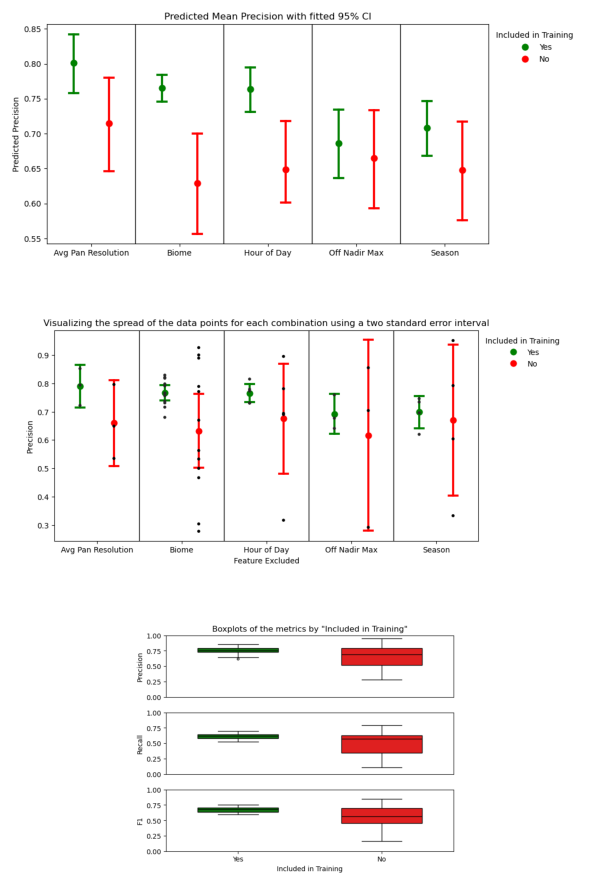

In [45]:
# Visualizations: SIE included/excluded training
metric = "precision"  # [precision, recall, f1]
display_sie_results(input_sie, metric=metric)